## Simple dynamic seq2seq with TensorFlow

This introduction covers building seq2seq using dynamic unrolling with TF.
TensorFlow has its own implementation of (seq2seq)[https://www.tensorflow.org/tutorials/seq2seq/]. However it uses static unrolling.

**Static unrolling** involves construction of computation graph with a fixed sequence of time step. One solution for handling sequences of varying lengths is to create multiple graphs with different time lengths and separate the dataset into this buckets.


**Dynamic unrolling** instead uses control flow ops to process sequence step by step.

In [1]:
import numpy as np
import tensorflow as tf

### Data

In [2]:
x = [[5, 7, 8], [6, 3], [3], [1]]

Data‘s layout is [max_time, batch_size], called time-major.

In [40]:
def batch(inputs, max_sequence_length = None):
    seq_len = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(seq_len)
    inputs_batch = np.zeros([max_sequence_length, batch_size], dtype = np.int32)
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch[j, i] = element
    return inputs_batch, seq_len

In [4]:
xt, xlen = batch(x)

In [5]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

### Building a model

#### Model inputs and outputs

In [6]:
PAD = 0
EOS = 1
vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 20
decoder_hidden_units = 20

In [7]:
# shape = [max_time, batch_size]
encoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32, name='encoder_inputs')
decoder_target = tf.placeholder(shape = (None, None), dtype = tf.int32, name='decoder_target')
decoder_inputs = tf.placeholder(shape = (None, None), dtype=tf.int32, name='decoder_inputs')

In [8]:
# Embeddings
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype = tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

#### Encoder

In [9]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)
_, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded, dtype = tf.float32,  time_major = True)

TensorFlow LSTM implementation stores state as a tuple of tensors.

In [10]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

#### Decoder

In [11]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [12]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_logits

<tf.Tensor 'fully_connected/Reshape_1:0' shape=(?, ?, 10) dtype=float32>

In [13]:
decoder_prediction = tf.argmax(decoder_logits, 2)

#### Optimizer

In [15]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_target, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

#### Test forward pass
When building a Graph, TF will throw errors when static shapes are not matching. However, mismatches between dynamic shapes are often only discovered when we try to run something through the graph.

In [18]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[8 2 9]
 [8 8 0]
 [7 7 7]
 [7 7 7]]


#### Train
Train our model to memorize and reproduce input sequence

In [19]:
def random_sequences(length_from, length_to,
                     vocab_lower, vocab_upper,
                     batch_size):
    """ Generates batches of random integer sequences,
        sequence length in [length_from, length_to],
        vocabulary in [vocab_lower, vocab_upper]
    """
    if length_from > length_to:
            raise ValueError('length_from > length_to')

    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to + 1)
    
    while True:
        yield [
            np.random.randint(low=vocab_lower,
                              high=vocab_upper,
                              size=random_length()).tolist()
            for _ in range(batch_size)
        ]

In [20]:
batch_size = 100

batches = random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[9, 5, 8, 5, 8, 2]
[9, 5, 7, 6, 3]
[9, 7, 8, 8, 4]
[6, 4, 6]
[6, 5, 6, 2, 6, 6]
[8, 9, 7, 5, 4, 8, 9]
[3, 9, 9, 2]
[3, 7, 8, 7, 4, 9]
[3, 4, 9, 6, 8, 4]
[5, 6, 3, 9, 4, 7, 8, 8]


In [43]:
def next_feed():
    bat = next(batches)
    encoder_inputs_, _ = batch(bat)
    decoder_targets_, _ = batch(
        [(sequence) + [EOS] for sequence in bat]
    )
    decoder_inputs_, _ = batch(
        [[EOS] + (sequence) for sequence in bat]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_target: decoder_targets_,
    }

In [49]:
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    try:
        for bat in range(max_batches):
            fd = next_feed()
            _, l = sess.run([train_op, loss], fd)
            loss_track.append(l)

            if bat == 0 or bat % batches_in_epoch == 0:
                print('batch {}'.format(bat))
                print('  minibatch loss: {}'.format(sess.run(loss, fd)))
                predict_ = sess.run(decoder_prediction, fd)
                for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                    print('  sample {}:'.format(i + 1))
                    print('    input     > {}'.format(inp))
                    print('    predicted > {}'.format(pred))
                    if i >= 2:
                        break
                print()
    except KeyboardInterrupt:
        print('training interrupted')

batch 0
  minibatch loss: 2.3261539936065674
  sample 1:
    input     > [6 7 3 7 2 3 0 0]
    predicted > [9 9 4 0 0 4 0 7 3]
  sample 2:
    input     > [8 4 8 0 0 0 0 0]
    predicted > [9 9 9 0 3 3 3 3 3]
  sample 3:
    input     > [8 2 9 9 3 6 0 0]
    predicted > [9 0 0 6 6 0 9 9 3]

batch 1000
  minibatch loss: 0.3551306128501892
  sample 1:
    input     > [5 4 5 4 9 3 4 2]
    predicted > [5 4 5 4 9 4 4 2 1]
  sample 2:
    input     > [9 3 2 8 5 2 9 0]
    predicted > [9 3 2 5 5 2 9 1 0]
  sample 3:
    input     > [5 4 6 6 2 6 0 0]
    predicted > [5 6 6 6 2 6 1 0 0]

batch 2000
  minibatch loss: 0.18548312783241272
  sample 1:
    input     > [8 9 7 7 7 3 0 0]
    predicted > [8 7 7 7 7 3 1 0 0]
  sample 2:
    input     > [4 3 4 6 0 0 0 0]
    predicted > [4 3 4 6 1 0 0 0 0]
  sample 3:
    input     > [5 7 7 6 2 7 0 0]
    predicted > [7 7 7 6 2 7 1 0 0]

batch 3000
  minibatch loss: 0.12836958467960358
  sample 1:
    input     > [6 6 8 5 4 9 5 0]
    predicted > [6 6 8

loss 0.1269 after 300100 examples (batch_size=100)


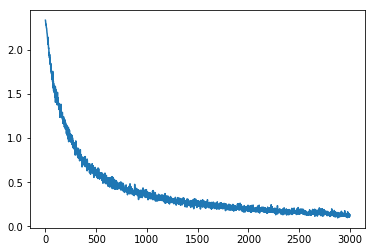

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))